In [ ]:
# Project: House Prices: Advanced Regression Techniques

# Preprocessing steps:
# 1. Columns with more than 80% NaN vales, same values are dropped
# 2. Converting Categorical to Numerical values
#      i. Used Integer Mapping for some columns with similar values
#     ii. Used Label Encoder
# 3. Missing values are populated using Iterative Imputer
# 4. Data is scaled using Standard Scaler
# 5. Features are selected using RFECV

# 1. Five Regression Models are applied with 10-Fold CV to the processed datasets
#      i. LinearRegression
#     ii. KNeighborsRegressor
#    iii. CatBoostRegressor
#     iv. GradientBoostingRegressor
#      v. RandomForestRegressor
# 2. Models are evaluated with MAE, MSE, RMSE, R2

# Used pycaret on the dataset and compared the results using r2 scores

In [45]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from pycaret.regression import *

In [46]:
df = pd.read_csv('C:/Users/rikky/Downloads/house-prices-advanced-regression-techniques/train.csv')

In [47]:
# Column names and number of NaNs
[print(x, df[x].isna().sum()) for x in df.columns[df.isna().any()].tolist()]

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [48]:
duplicate_df = df.copy()

In [49]:
# More than 80% of below column values are NaNs, so removing these columns.
duplicate_df=duplicate_df.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])
#drop redundant columns- Utlities values are largely the same for all inputs
duplicate_df=duplicate_df.drop(columns=['Utilities','Id'])

In [50]:
#converting categorical ordinal values to numerical values using integer mapping
rank_to_num= {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

for column in duplicate_df[['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']]:
    duplicate_df[column]=duplicate_df[column].map(rank_to_num)


# Convert categorical values to Numerical values using LabelEncoder
objectDataTypeColumns = list(duplicate_df.select_dtypes(include=['object']).columns)
#objectDataTypeColumns

encoder = LabelEncoder()
for i in objectDataTypeColumns:
    duplicate_df[i] = encoder.fit_transform(duplicate_df[i].astype('str'))

In [51]:
#imputing missing values using IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(duplicate_df)
imputed_df = imp.transform(duplicate_df)
imputed_df = pd.DataFrame(imputed_df, columns=duplicate_df.columns)
imputed_df= imputed_df.apply(np.ceil)
imputed_df.head(20)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0         60.0       3.0         65.0   8450.0     1.0       3.0          3.0   
1         20.0       3.0         80.0   9600.0     1.0       3.0          3.0   
2         60.0       3.0         68.0  11250.0     1.0       0.0          3.0   
3         70.0       3.0         60.0   9550.0     1.0       0.0          3.0   
4         60.0       3.0         84.0  14260.0     1.0       0.0          3.0   
5         50.0       3.0         85.0  14115.0     1.0       0.0          3.0   
6         20.0       3.0         75.0  10084.0     1.0       3.0          3.0   
7         60.0       3.0         87.0  10382.0     1.0       0.0          3.0   
8         50.0       4.0         51.0   6120.0     1.0       3.0          3.0   
9        190.0       3.0         50.0   7420.0     1.0       3.0          3.0   
10        20.0       3.0         70.0  11200.0     1.0       3.0          3.0   
11        60.0       3.0         85.0  11924.0     1.0       0.0          3.0   
12        20.0       3.0         62.0  12968.0     1.0       1.0          3.0   
13        20.0       3.0         91.0  10652.0     1.0       0.0          3.0   
14        20.0       3.0         85.0  10920.0     1.0       0.0          3.0   
15        45.0       4.0         51.0   6120.0     1.0       3.0          3.0   
16        20.0       3.0         81.0  11241.0     1.0       0.0          3.0   
17        90.0       3.0         72.0  10791.0     1.0       3.0          3.0   
18        20.0       3.0         66.0  13695.0     1.0       3.0          3.0   
19        20.0       3.0         70.0   7560.0     1.0       3.0          3.0   

    LotConfig  LandSlope  Neighborhood  ...  EnclosedPorch  3SsnPorch  \
0         4.0        0.0           5.0  ...            0.0        0.0   
1         2.0        0.0          24.0  ...            0.0        0.0   
2         4.0        0.0           5.0  ...            0.0        0.0   
3         0.0        0.0           6.0  ...          272.0        0.0   
4         2.0        0.0          15.0  ...            0.0        0.0   
5         4.0        0.0          11.0  ...            0.0      320.0   
6         4.0        0.0          21.0  ...            0.0        0.0   
7         0.0        0.0          14.0  ...          228.0        0.0   
8         4.0        0.0          17.0  ...          205.0        0.0   
9         0.0        0.0           3.0  ...            0.0        0.0   
10        4.0        0.0          19.0  ...            0.0        0.0   
11        4.0        0.0          16.0  ...            0.0        0.0   
12        4.0        0.0          19.0  ...            0.0        0.0   
13        4.0        0.0           5.0  ...            0.0        0.0   
14        0.0        0.0          12.0  ...          176.0        0.0   
15        0.0        0.0           3.0  ...            0.0        0.0   
16        1.0        0.0          12.0  ...            0.0        0.0   
17        4.0        0.0          19.0  ...            0.0        0.0   
18        4.0        0.0          20.0  ...            0.0        0.0   
19        4.0        0.0          12.0  ...            0.0        0.0   

    ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
0           0.0       0.0      0.0     2.0  2008.0       8.0            4.0   
1           0.0       0.0      0.0     5.0  2007.0       8.0            4.0   
2           0.0       0.0      0.0     9.0  2008.0       8.0            4.0   
3           0.0       0.0      0.0     2.0  2006.0       8.0            0.0   
4           0.0       0.0      0.0    12.0  2008.0       8.0            4.0   
5           0.0       0.0    700.0    10.0  2009.0       8.0            4.0   
6           0.0       0.0      0.0     8.0  2007.0       8.0            4.0   
7           0.0       0.0    350.0    11.0  2009.0       8.0            4.0   
8           0.0       0.0      0.0     4.0  2008.0       

In [55]:
#creating x and y variables for models from imputed_df and scaling data
features = list(imputed_df.columns)
features
target = features.pop()
target

x = imputed_df.loc[:, features].values
y = imputed_df.loc[:, target].values

scaler= StandardScaler()
x_scaled= scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2,random_state=42)

In [54]:
# Linear Regression without selected features to compare train test results

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

#print(regressor.intercept_)
#print(regressor.coef_)
#print(features, regressor.coef_)

print("Training R-Squared: ", regressor.score(x_train, y_train))
print("Testing R-Squared: ", regressor.score(x_test, y_test))

Training R-Squared:  0.838941735467868
Testing R-Squared:  0.8459333652142239


In [56]:
#RFE with cross validation to remove features

estimator = GradientBoostingRegressor() 
rfecv = RFECV(estimator, step=0.2, cv=5)
selector = rfecv.fit(x_scaled, y)
mask= selector.support_
#selector = selector.fit(x, y)

print(mask)
selector.n_features_

[False  True  True  True False False  True False False  True  True False
  True False  True  True  True  True  True False  True False False  True
  True False False  True False  True  True  True False  True  True  True
 False False  True False  True  True False  True  True False  True False
  True False  True  True  True  True False  True  True  True  True  True
 False False  True  True  True False  True  True  True False  True False
 False  True]


46

([], <a list of 0 Text yticklabel objects>)

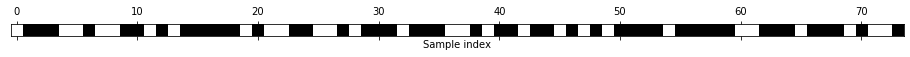

In [57]:
# Gray Scale plot to indicate the selected features
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [58]:
# Creating a new dataframe with selected features
indicesList = list(np.where(mask)[0])
indicesList

reduced_df = imputed_df.iloc[:, indicesList]
reduced_df

MSZoning  LotFrontage  LotArea  LandContour  Neighborhood  Condition1  \
0          3.0         65.0   8450.0          3.0           5.0         2.0   
1          3.0         80.0   9600.0          3.0          24.0         1.0   
2          3.0         68.0  11250.0          3.0           5.0         2.0   
3          3.0         60.0   9550.0          3.0           6.0         2.0   
4          3.0         84.0  14260.0          3.0          15.0         2.0   
...        ...          ...      ...          ...           ...         ...   
1455       3.0         62.0   7917.0          3.0           8.0         2.0   
1456       3.0         85.0  13175.0          3.0          14.0         2.0   
1457       3.0         66.0   9042.0          3.0           6.0         2.0   
1458       3.0         68.0   9717.0          3.0          12.0         2.0   
1459       3.0         75.0   9937.0          3.0           7.0         2.0   

      BldgType  OverallQual  OverallCond  YearBuilt  ...  GarageCars  \
0          0.0          7.0          5.0     2003.0  ...         2.0   
1          0.0          6.0          8.0     1976.0  ...         2.0   
2          0.0          7.0          5.0     2001.0  ...         2.0   
3          0.0          7.0          5.0     1915.0  ...         3.0   
4          0.0          8.0          5.0     2000.0  ...         3.0   
...        ...          ...          ...        ...  ...         ...   
1455       0.0          6.0          5.0     1999.0  ...         2.0   
1456       0.0          6.0          6.0     1978.0  ...         2.0   
1457       0.0          7.0          9.0     1941.0  ...         1.0   
1458       0.0          5.0          6.0     1950.0  ...         1.0   
1459       0.0          5.0          6.0     1965.0  ...         1.0   

      GarageArea  PavedDrive  WoodDeckSF  OpenPorchSF  3SsnPorch  ScreenPorch  \
0          548.0         2.0         0.0         61.0        0.0          0.0   
1          460.0         2.0       298.0          0.0        0.0          0.0   
2          608.0         2.0         0.0         42.0        0.0          0.0   
3          642.0         2.0         0.0         35.0        0.0          0.0   
4          836.0         2.0       192.0         84.0        0.0          0.0   
...          ...         ...         ...          ...        ...          ...   
1455       460.0         2.0         0.0         40.0        0.0          0.0   
1456       500.0         2.0       349.0          0.0        0.0          0.0   
1457       252.0         2.0         0.0         60.0        0.0          0.0   
1458       240.0         2.0       366.0          0.0        0.0          0.0   
1459       276.0         2.0       736.0         68.0        0.0          0.0   

      PoolArea  MoSold  SaleCondition  
0          0.0     2.0            4.0  
1          0.0     5.0            4.0  
2          0.0     9.0            4.0  
3          0.0     2.0            0.0  
4          0.0    12.0            4.0  
...        ...     ...            ...  
1455       0.0     8.0            4.0  
1456       0.0     2.0            4.0  
1457       0.0     5.0            4.0  
1458       0.0     4.0            4.0  
1459       0.0     6.0            4.0  

[1460 rows x 46 columns]

In [59]:
#creating x1 and y1 variables for models from reduced_df and scaling data

selected_features = list(reduced_df.columns)
#selected_features

reduced_df['SalePrice'] = imputed_df['SalePrice'].values

x1 = reduced_df.loc[:, selected_features].values
y1 = reduced_df.loc[:, target].values

scaled_x1= scaler.fit_transform(x1)

X_train, X_test, y_train, y_test = train_test_split(scaled_x1, y1, test_size = 0.2,random_state=42)

# Using negative evaluation metrics for regression as only this is available 
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

# Using negative scores as cross_validation function negates the scores which are meant to be minimized.
# Scores that are meant to be maximized such as R2 are left positive.
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

C:\Users\rikky\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
# Linear Regression with selected features to compare train test results after RFECV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#print(regressor.intercept_)
#print(regressor.coef_)
#print(features, regressor.coef_)

print("Training R-Squared: ", regressor.score(X_train, y_train))
print("Testing R-Squared: ", regressor.score(X_test, y_test))

Training R-Squared:  0.8265962602206756
Testing R-Squared:  0.8450249086662127


In [39]:
# Linear Regression with selected features

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)

#print(regressor.intercept_)
#print(regressor.coef_)
#print(features, regressor.coef_)

# print("MAE : ",metrics.mean_absolute_error(y_test, y_pred))
# print("MSE : ",metrics.mean_squared_error(y_test, y_pred))
# print("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Training R-Squared: ", regressor.score(X_train, y_train))
# print("Testing R-Squared: ", regressor.score(X_test, y_test))

scores = cross_validate(regressor, scaled_x1, y1, cv=10, 
 scoring=scoring)

print("10Fold Cross Validation Results Linear Regression:")
print("MAE : ",np.mean(-scores['test_neg_mean_absolute_error']))
print("MSE : ",np.mean(-scores['test_neg_mean_squared_error']))
print("RMSE : ",np.mean(-scores['test_neg_root_mean_squared_error']))
print("R2 Square : ",np.mean(scores['test_r2']))

10Fold Cross Validation Results Linear Regression:
MAE :  20752.19226993096
MSE :  1252827855.655745
RMSE :  33611.00847570259
R2 Square :  0.811554522346863


In [40]:
#KNRegression on reduced features and GridSearchCV is used to identify best n_neighbors

knnReg = KNeighborsRegressor()

param_grid = {'n_neighbors': np.arange(1, 25)}

knn_gscv = GridSearchCV(knnReg, param_grid, cv=5)

knn_gscv.fit(scaled_x1, y1)

paramsDict = knn_gscv.best_params_
n_neighbor = paramsDict['n_neighbors']

knnmodel= KNeighborsRegressor(n_neighbors=n_neighbor)

# knreg=knnmodel.fit(x_train, y_train)
# y_pred=knreg.predict(x_test)
# print("Training R-Squared: ", knreg.score(x_train, y_train))
# print("Testing R-Squared: ", knreg.score(x_test, y_test))
# print('MSE:' , mean_squared_error(y_test, y_pred))
# print('RMSE:' , np.sqrt(mean_squared_error(y_test, y_pred)))

scores = cross_validate(knnmodel, scaled_x1, y1, cv=10, 
 scoring=scoring)

print("10Fold Cross Validation Results Linear Regression:")
print("MAE : ",np.mean(-scores['test_neg_mean_absolute_error']))
print("MSE : ",np.mean(-scores['test_neg_mean_squared_error']))
print("RMSE : ",np.mean(-scores['test_neg_root_mean_squared_error']))
print("R2 Square : ",np.mean(scores['test_r2']))

10Fold Cross Validation Results Linear Regression:
MAE :  20806.835540334858
MSE :  1253236975.9685526
RMSE :  34536.11039412839
R2 Square :  0.8072105240025431


In [41]:
# Gradient Boosting Regression with selected feature 

gradientBR=GradientBoostingRegressor(n_estimators=100) 

# gradientBR.fit(X_train, y_train) 
# y_pred=gradientBR.predict(X_test)

# print(gradientBR.feature_importances_)
# print("MAE : ",metrics.mean_absolute_error(y_test, y_pred))
# print("MSE : ",metrics.mean_squared_error(y_test, y_pred))
# print("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Training R-Squared: ", gradientBR.score(X_train, y_train))
# print("Testing R-Squared: ", gradientBR.score(X_test, y_test))

scores = cross_validate(gradientBR, scaled_x1, y1, cv=10, 
 scoring=scoring)

print("10Fold Cross Validation Results Linear Regression:")
print("MAE : ",np.mean(-scores['test_neg_mean_absolute_error']))
print("MSE : ",np.mean(-scores['test_neg_mean_squared_error']))
print("RMSE : ",np.mean(-scores['test_neg_root_mean_squared_error']))
print("R2 Square : ",np.mean(scores['test_r2']))

10Fold Cross Validation Results Linear Regression:
MAE :  15822.48957763165
MSE :  648787729.3463318
RMSE :  25083.92514536113
R2 Square :  0.8961272118396006


In [42]:
# Cat Boost Regression with selected feature 

cbReg=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
##cbReg.fit(X_train, y_train)

#y_pred = cbReg.predict(X_test)
# print("MAE : ",metrics.mean_absolute_error(y_test, y_pred))
# print("MSE : ",metrics.mean_squared_error(y_test, y_pred))
# print("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Training R-Squared: ", model.score(X_train, y_train))
# print("Testing R-Squared: ", model.score(X_test, y_test))

scores = cross_validate(cbReg, scaled_x1, y1, cv=10, 
 scoring=scoring)

print("10Fold Cross Validation Results Linear Regression:")
print("MAE : ",np.mean(-scores['test_neg_mean_absolute_error']))
print("MSE : ",np.mean(-scores['test_neg_mean_squared_error']))
print("RMSE : ",np.mean(-scores['test_neg_root_mean_squared_error']))
print("R2 Square : ",np.mean(scores['test_r2']))

0:	learn: 75793.7516353	total: 61.8ms	remaining: 3.03s
1:	learn: 71464.8133049	total: 62.9ms	remaining: 1.51s
2:	learn: 67407.1383910	total: 63.7ms	remaining: 998ms
3:	learn: 64304.0441940	total: 64.8ms	remaining: 745ms
4:	learn: 61091.4531125	total: 65.7ms	remaining: 591ms
5:	learn: 57943.1598138	total: 66.7ms	remaining: 489ms
6:	learn: 55681.6084986	total: 67.5ms	remaining: 415ms
7:	learn: 53125.9548757	total: 68.4ms	remaining: 359ms
8:	learn: 50820.6491213	total: 69.4ms	remaining: 316ms
9:	learn: 48899.0059193	total: 70.2ms	remaining: 281ms
10:	learn: 47205.4578227	total: 71.2ms	remaining: 252ms
11:	learn: 45460.4878647	total: 72.4ms	remaining: 229ms
12:	learn: 43952.1443588	total: 73.6ms	remaining: 209ms
13:	learn: 42541.7181550	total: 74.3ms	remaining: 191ms
14:	learn: 41184.4444199	total: 75.1ms	remaining: 175ms
15:	learn: 39942.0533216	total: 75.9ms	remaining: 161ms
16:	learn: 38866.1123940	total: 76.8ms	remaining: 149ms
17:	learn: 37891.6506276	total: 78.5ms	remaining: 140ms
18

0:	learn: 74378.2234643	total: 1.48ms	remaining: 72.4ms
1:	learn: 70606.4053301	total: 2.36ms	remaining: 56.7ms
2:	learn: 66641.1092930	total: 3.2ms	remaining: 50.1ms
3:	learn: 63329.0610746	total: 4ms	remaining: 46ms
4:	learn: 59935.6264539	total: 4.82ms	remaining: 43.4ms
5:	learn: 56986.8594619	total: 5.71ms	remaining: 41.9ms
6:	learn: 54507.5814861	total: 6.5ms	remaining: 40ms
7:	learn: 52033.3884118	total: 7.25ms	remaining: 38.1ms
8:	learn: 49933.4783517	total: 8ms	remaining: 36.5ms
9:	learn: 47758.7410218	total: 8.75ms	remaining: 35ms
10:	learn: 46000.3343712	total: 9.56ms	remaining: 33.9ms
11:	learn: 44283.5091557	total: 10.3ms	remaining: 32.6ms
12:	learn: 42882.8735705	total: 11.1ms	remaining: 31.5ms
13:	learn: 41429.2946997	total: 11.9ms	remaining: 30.6ms
14:	learn: 40055.8455753	total: 12.6ms	remaining: 29.5ms
15:	learn: 38874.5678457	total: 13.5ms	remaining: 28.6ms
16:	learn: 37692.0772900	total: 14.3ms	remaining: 27.7ms
17:	learn: 36665.3614199	total: 15.1ms	remaining: 26.9m

32:	learn: 30650.2851526	total: 37.2ms	remaining: 19.1ms
33:	learn: 30340.2269368	total: 38ms	remaining: 17.9ms
34:	learn: 29886.1363090	total: 38.8ms	remaining: 16.6ms
35:	learn: 29549.1558478	total: 40.4ms	remaining: 15.7ms
36:	learn: 29050.0048616	total: 42.8ms	remaining: 15ms
37:	learn: 28767.3951730	total: 43.7ms	remaining: 13.8ms
38:	learn: 28524.7217473	total: 44.5ms	remaining: 12.5ms
39:	learn: 28124.7572389	total: 45.3ms	remaining: 11.3ms
40:	learn: 27952.4640695	total: 46.2ms	remaining: 10.1ms
41:	learn: 27736.8833669	total: 47ms	remaining: 8.95ms
42:	learn: 27430.3999982	total: 47.7ms	remaining: 7.77ms
43:	learn: 27171.8084403	total: 48.5ms	remaining: 6.61ms
44:	learn: 27028.4713241	total: 49.3ms	remaining: 5.47ms
45:	learn: 26864.9512858	total: 50.1ms	remaining: 4.36ms
46:	learn: 26649.8253755	total: 51ms	remaining: 3.25ms
47:	learn: 26409.6547486	total: 52ms	remaining: 2.17ms
48:	learn: 26216.3734717	total: 54.2ms	remaining: 1.11ms
49:	learn: 26071.2255041	total: 55.7ms	re

In [43]:
# Random Forest Regression with selected feature 

rfReg = RandomForestRegressor(n_estimators = 100, random_state = 42)

# rfReg.fit(X_train, y_train) 
# y_pred=rfReg.predict(X_test)

# print(gradientBR.feature_importances_)

# print("MAE : ",metrics.mean_absolute_error(y_test, y_pred))
# print("MSE : ",metrics.mean_squared_error(y_test, y_pred))
# print("RMSE : ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Training R-Squared: ", gradientBR.score(X_train, y_train))
# print("Testing R-Squared: ", gradientBR.score(X_test, y_test))

scores = cross_validate(rfReg, scaled_x1, y, cv=10, 
 scoring=scoring)

print("10Fold Cross Validation Results Linear Regression:")
print("MAE : ",np.mean(-scores['test_neg_mean_absolute_error']))
print("MSE : ",np.mean(-scores['test_neg_mean_squared_error']))
print("RMSE : ",np.mean(-scores['test_neg_root_mean_squared_error']))
print("R2 Square : ",np.mean(scores['test_r2']))

10Fold Cross Validation Results Linear Regression:
MAE :  16988.056449119373
MSE :  808665309.184131
RMSE :  27899.366885008803
R2 Square :  0.8722112520183305


In [45]:
# Compare models using pycaret

exp = setup(reduced_df, target = 'SalePrice', normalize = True)

 
Setup Succesfully Completed!


In [46]:
 compare_models()

In [ ]:
# Comparing Models

# Based on R2                  our impl model values         pycaret values
1. Gradient Boost Regression -       0.8961                     0.8775
2. Random Forest Regression  -       0.8722                     0.8548
3. CatBoost Regression       -       0.8477                     0.8841
4. Linear Regression         -       0.8115                     0.7785
5. K Neighbors Regression    -       0.8072                     0.7605